In [75]:
from src.TimeSeries import TimeSeries
import yfinance as yf

# Descargar cotizaciones de MELI (Mercado Libre)
meli = yf.download('MELI', start='2022-01-01', interval='1d')
dates = meli.index
meli_prices = meli['Close']['MELI']

ts = TimeSeries('$MELI', dates, meli_prices)

[*********************100%***********************]  1 of 1 completed


## Estacionariedad

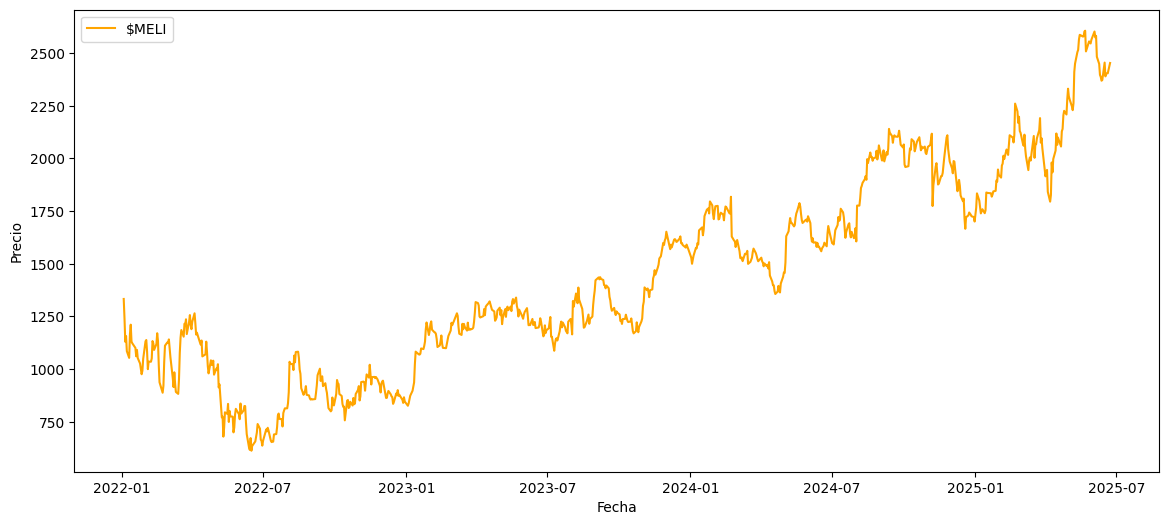

In [76]:
from src.TimeSeriesPlot import TimeSeriesPlot

plot = TimeSeriesPlot(ts)
plot.add_original()
plot.show()

In [77]:
ts.is_stationary()

ADF Statistic: -0.4235121156905513
p-value: 0.9060984622970027

KPSS Statistic: 0.33622588596180747
p-value: 0.01

Decisión: No estacionaria


False

Serie no es estacionaria, probablemente por el trend

In [78]:
diff_times = 1
ts_diff = ts.differentiate(diff_times)

ts_diff.is_stationary()

ADF Statistic: -29.585276091572652
p-value: 0.0

KPSS Statistic: 0.03364962898827431
p-value: 0.1

Decisión: Estacionaria


True

Requiere solo una diferenciación para ser estacionaria. Dato para ARIMA.

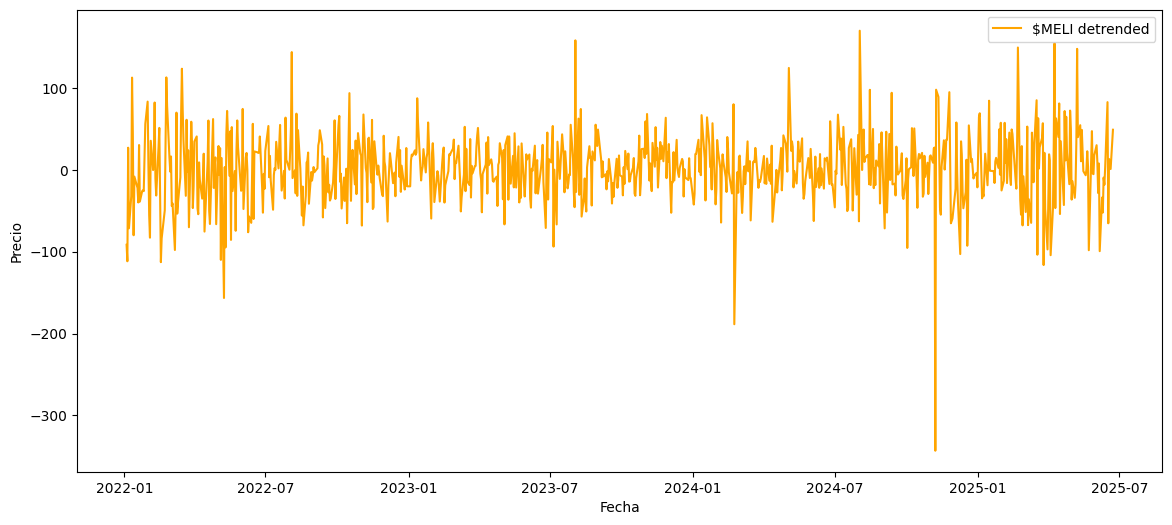

In [79]:
plot = TimeSeriesPlot(ts_diff)
plot.add_original()
plot.show()

## Forecasting 1: ARIMA

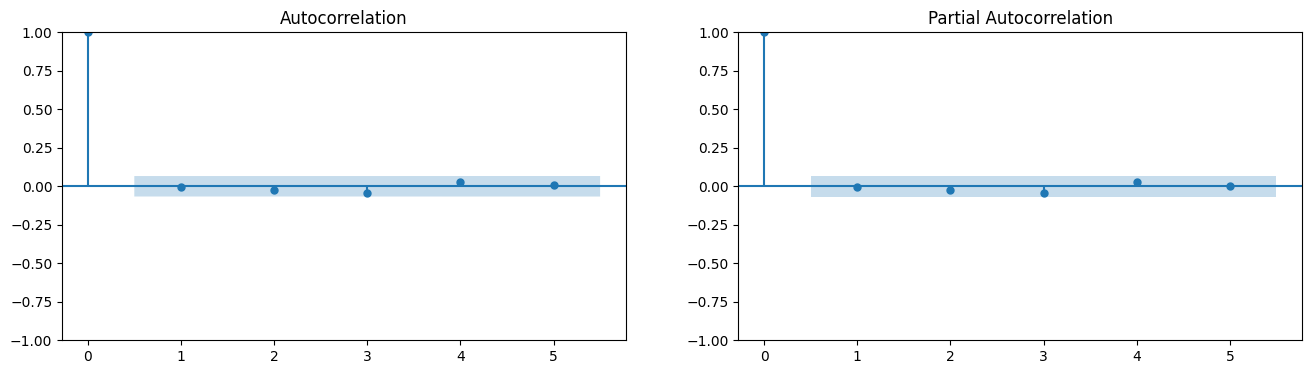

In [80]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(ts_diff.values, ax=axes[0], lags=5)
plot_pacf(ts_diff.values, ax=axes[1], lags=5)
plt.show()


* **p** es el número de términos autoregresivos (AR): cuántos valores pasados influencian el actual.
* **q** es el número de términos de media móvil (MA): cuántos errores pasados se usan.
* **d** es el número de diferenciaciones necesarias para hacer la serie original no estacionaria, en estacionaria.

### Cómo elegirlos:

- Tanto ACF como PACF cortan abruptamente, no desvanecen.
- Tanto p como q se eligen mirando el punto donde cortan, es decir, el último lag significativo antes de que los valores caigan dentro del intervalo de confianza.
    - Si PACF corta en lag k → p = k
    - Si ACF corta en lag k → q = k


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

modelo = ARIMA(ts.values, order=(1,diff_times,1))  # p=1, d=1, q=1 por lo mencionado anteriormente
resultado = modelo.fit()
#print(resultado.summary())

In [83]:
#resultado.plot_diagnostics(figsize=(12,8))

### Rolling Forecast evaluativo con Test

Simulamos que se van agregando los datos de test de a uno en cada paso, y luego es utilizado para su reentrenamiento. Es decir, simulamos la predicción diaria/semanal, tomando los nuevos datos para predecir al siguiente día nuevamente.


In [84]:
import numpy as np
from sklearn.metrics import mean_squared_error

#ARIMA
# División 70% entrenamiento, 30% test
size = int(len(ts.values) * 0.7)
train, test = ts.values[:size], ts.values[size:]

history = train.tolist()
predictions = []

# Rolling forecast paso a paso
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    forecast = model_fit.forecast()          # pronóstico 1 paso adelante
    yhat = forecast[0]                       # valor pronosticado
    predictions.append(yhat)                 # guardar pronóstico
    obs = test.iloc[t]                       # dato real
    history.append(obs)                      # actualizar historial con valor real

/home/neville/GitHub/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/neville/GitHub/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RMSE Rolling ARIMA: 49.7462


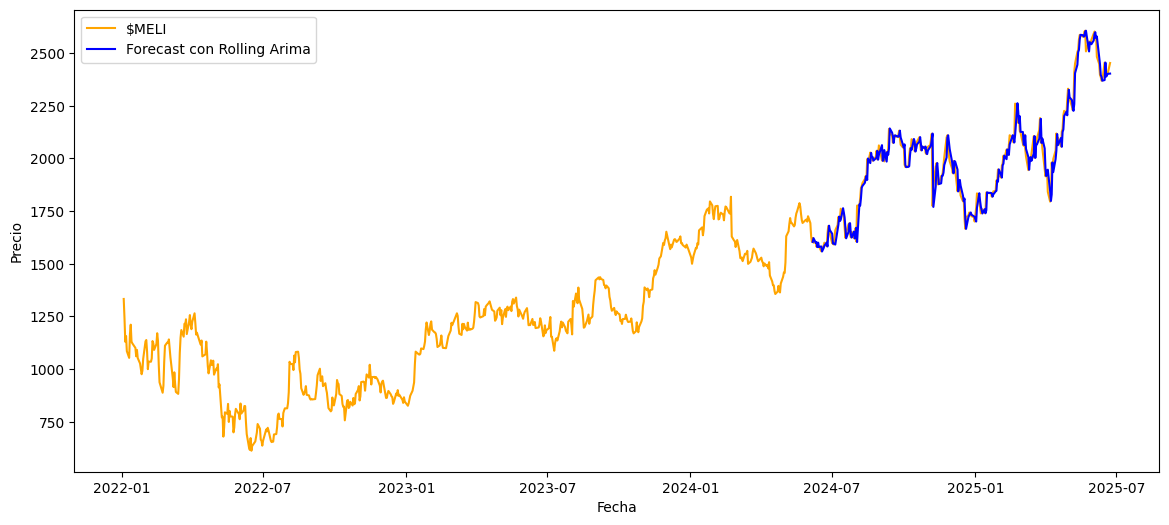

In [85]:
# Calcular RMSE
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print(f'RMSE Rolling ARIMA: {rmse:.4f}')

ts_forecast = TimeSeries('Forecast con Rolling Arima', ts.dates[size:], predictions)

plot = TimeSeriesPlot(ts)
plot.add_original()
plot.add_another(ts_forecast, 'blue')
plot.show()

### Rolling forecast hacia futuro

En este caso, tomamos los datos que predijimos en cada fecha para luego reentrenar el modelo (es decir, no actualizamos con test, sino con el de dato forecasteado)

In [89]:
# Inicializar con toda la serie conocida
history = ts.values.tolist()

n_steps = 20  # pasos hacia el futuro a predecir
future_predictions = []

for _ in range(n_steps):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    forecast = model_fit.forecast()          # un paso adelante
    yhat = forecast[0]
    future_predictions.append(yhat)
    history.append(yhat)                     # actualizo con predicción

/home/neville/GitHub/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/neville/GitHub/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [90]:
import pandas as pd

last_date = ts.dates[-1]
future_dates = [last_date + pd.Timedelta(days=i+1) for i in range(n_steps)]

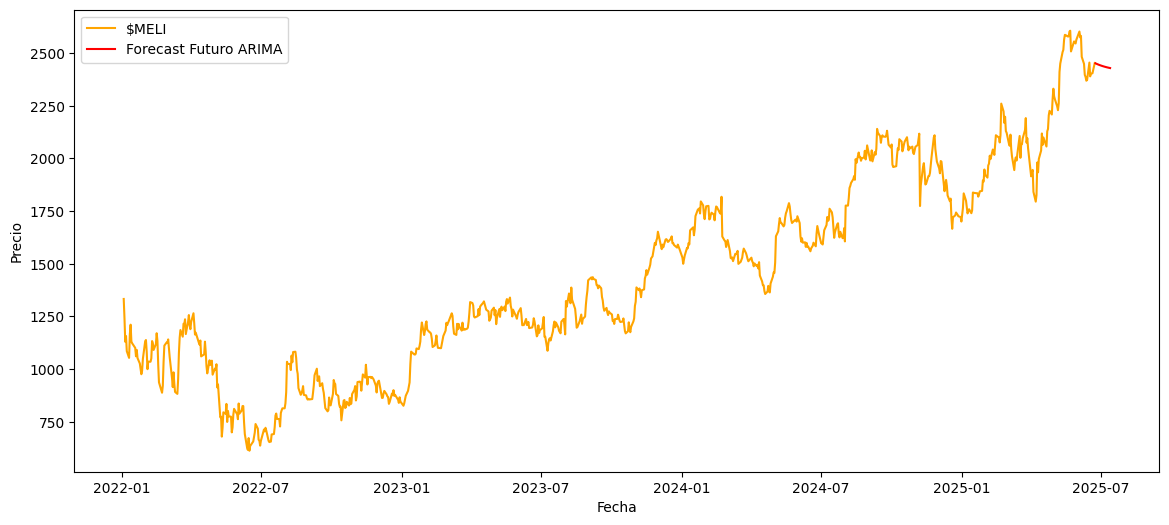

In [91]:
ts_forecast_future = TimeSeries('Forecast Futuro ARIMA', future_dates, future_predictions)

plot = TimeSeriesPlot(ts)
plot.add_original()
plot.add_another(ts_forecast_future)
plot.show()

## Forecasting 2: LSTMs (sobre serie detrended)

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import random
import tensorflow as tf

In [139]:
ts = ts.detrend_with_regression_fitting(1)

In [140]:
# Semilla para reproducibilidad
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

# Datos
values = ts.values.astype('float32')

# Normalización MinMax
scaler = MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(values.to_numpy().reshape(-1, 1))

# Split 70% train, 30% test
split_index = int(len(values_scaled) * 0.7)
train, test = values_scaled[:split_index], values_scaled[split_index:]

look_back = 5

# Función para crear datasets supervisados
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

# Crear datasets para train y test
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# --- Función para entrenar modelo stateful ---
def fit_lstm(trainX, trainY, epochs=1, neurons=4, batch_size=1, stateful=True):
    model = Sequential()
    model.add(Input(batch_shape=(batch_size, look_back, 1)))
    lstm_layer = LSTM(neurons, stateful=stateful)
    model.add(lstm_layer)
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    for i in range(epochs):
        model.fit(trainX, trainY, epochs=1, batch_size=batch_size, shuffle=False, verbose=0)
        lstm_layer.reset_states()   # Reseteo acá
    return model

# Ajustar batch_size a 1 para stateful y predicciones paso a paso
batch_size = 1
neurons = 50
epochs = 25

In [141]:
# --- Entrenar modelo para rolling forecast ---
model_rolling = fit_lstm(X_train, y_train, epochs=epochs, neurons=neurons, batch_size=batch_size, stateful=False)

# --- Rolling forecast ---
predictions_rolling = []
test_1d = test.reshape(-1)  # array 1D para slicing

for i in range(len(test_1d) - look_back):
    X_input = test_1d[i:i+look_back].reshape(1, look_back, 1)
    yhat = model_rolling.predict(X_input, batch_size=1, verbose=0)
    predictions_rolling.append(yhat[0, 0])

predictions_rolling_inv = scaler.inverse_transform(np.array(predictions_rolling).reshape(-1,1))
y_test_inv_rolling = scaler.inverse_transform(test[look_back:].reshape(-1,1))

rmse_rolling = np.sqrt(mean_squared_error(y_test_inv_rolling, predictions_rolling_inv))
print(f'Rolling LSTM RMSE: {rmse_rolling:.4f}')

forecast_dates_rolling = ts.dates[split_index + look_back:]
ts_forecast_rolling = TimeSeries(f'Rolling Forecast (batch_size={batch_size})', forecast_dates_rolling, predictions_rolling_inv.flatten())

Rolling LSTM RMSE: 64.2332


In [142]:
# --- Entrenar modelo para forecast normal ---
batch_size = 16

model_normal = fit_lstm(X_train, y_train, epochs=epochs, neurons=neurons, batch_size=batch_size, stateful=False)

# --- Forecast normal (batch predict) ---
predictions_normal = model_normal.predict(X_test, batch_size=batch_size)

predictions_normal_inv = scaler.inverse_transform(predictions_normal)
y_test_inv_normal = scaler.inverse_transform(y_test.reshape(-1,1))

rmse_normal = np.sqrt(mean_squared_error(y_test_inv_normal, predictions_normal_inv))
print(f'Normal LSTM RMSE: {rmse_normal:.4f}')

forecast_dates_normal = ts.dates[split_index + look_back:]
ts_forecast_normal = TimeSeries(f'Normal Forecast (batch_size={batch_size}', forecast_dates_normal, predictions_normal_inv.flatten())

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Normal LSTM RMSE: 64.8920


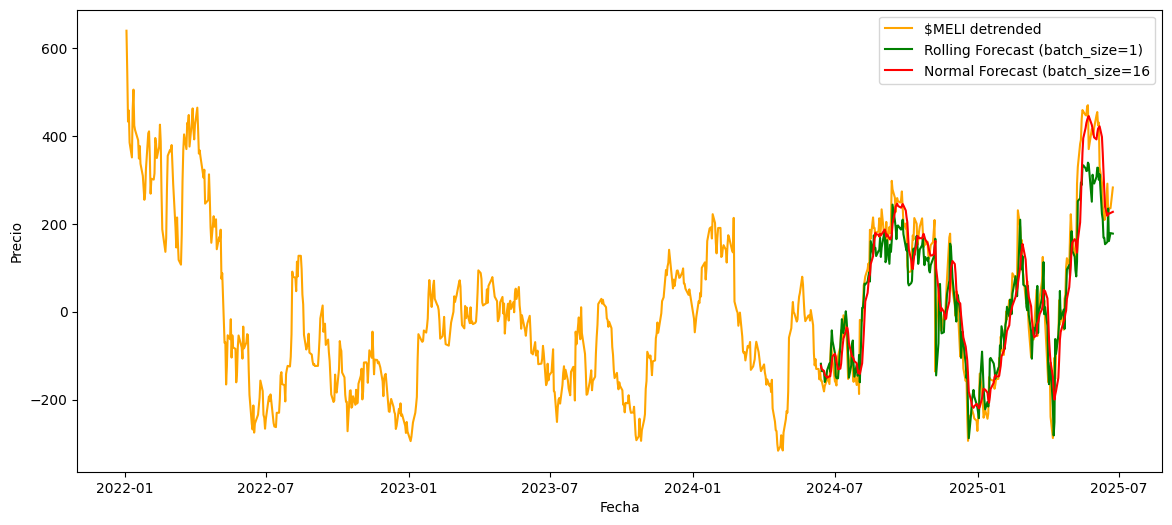

In [143]:
# --- Graficar ambos y la serie original ---
plot = TimeSeriesPlot(ts)
plot.add_original()
plot.add_another(ts_forecast_rolling, 'green')  # Rolling forecast
plot.add_another(ts_forecast_normal, 'red')    # Normal forecast
plot.show()

En este caso, el rolling genera predicciones más precisas a nivel diario (captura mejor el ruido intrasemanal, probablemente overfitteando), aunque el modelo entrenado normalmente y con batch_size de 16, se adapta mejor y genera predicciones más suavizadas y con menor error a largo plazo.

In [144]:
def forecast_future(model, last_sequence, n_steps, scaler):
    predictions = []
    current_seq = last_sequence.copy()  # forma (look_back, 1)

    for _ in range(n_steps):
        X_input = current_seq.reshape(1, look_back, 1)
        yhat = model.predict(X_input, verbose=0)
        predictions.append(yhat[0, 0])

        # Actualizar la secuencia
        current_seq = np.append(current_seq[1:], [[yhat[0, 0]]], axis=0)

    predictions_inv = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
    return predictions_inv

In [151]:
last_sequence = test_1d[-look_back:].reshape(-1, 1)  # última secuencia conocida
future_steps = 60  # días, pasos, etc. que quieras predecir

future_preds_rolling_model = forecast_future(model_rolling, last_sequence, future_steps, scaler)
future_pred_normal_model = forecast_future(model_normal, last_sequence, future_steps, scaler)

# Para fechas futuras:
last_date = ts.dates[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

ts_future_rolling = TimeSeries("Future Forecast (Rolling Model)", future_dates, future_preds_rolling_model.flatten())
ts_future_normal = TimeSeries("Future Rolling (Normal model)", future_dates, future_pred_normal_model.flatten())

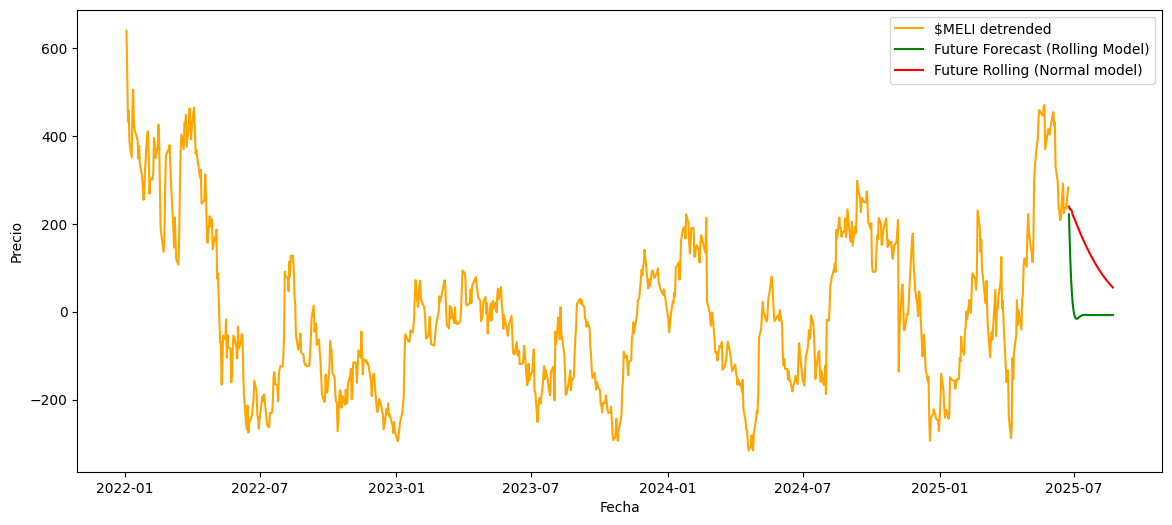

In [152]:
plot = TimeSeriesPlot(ts)
plot.add_original()
plot.add_another(ts_future_rolling, 'green')
plot.add_another(ts_future_normal, 'red')
plot.show()